# Base

In [1]:
#@title Install Graphing Requirements
!apt install graphviz graphviz-dev >/dev/null
!pip install pygraphviz >/dev/null

In [2]:
#@markdown ### Import Modules

from collections import defaultdict, namedtuple
from itertools import product
import networkx as nx
from numpy import array, mat, tile, zeros, append
from graphviz import Source
#%matplotlib inline

#@markdown ### Define Constants

colors = ['gray47',
					'deeppink',
					'violet',
					'mediumpurple',
					'steelblue',
					'springgreen',
					'yellow',
					'gold',
					'orange',
					'crimson']

#@markdown ### Define Functions

def getcolor():
	color = colors.pop()
	colors.insert(0, color)  # rotates colors
	return color

def replacements(txt, rs):
	if isinstance(rs, dict):
		rs = list(rs.items())
	for old, new in rs:
		txt = txt.replace(old, str(new))
	return txt


In [3]:
#@title Accept Class

class Accept():

  def __init__(self, _bool, string, txt):
    self._bool = _bool
    self.string = string
    self.txt = txt

  def __bool__(self):
    return self._bool

  def __str__(self):
    _is = 'is not'
    if self:
      _is = 'is'
    return '\n'.join([
        f'{self.string} {_is} accepted:', 
        self.txt,
    ])


# DFA

In [4]:
#@title DFA Class

class DFA():

  def __init__(self, txt):

    self.color = getcolor()

    lines = [line.strip() for line in txt.split('\n') if line.strip()]

    self.Q = lines.pop(0).split()
    self.index = {q:self.Q.index(q) for q in self.Q}
    assert(len(set(self.Q)) == len(self.Q))

    self.Sigma = lines.pop(0).split()

    self.extract_delta(lines[:-2])
    assert self.d.shape == (len(self.Q), len(self.Sigma))

    self.S = lines.pop(-2)
    assert self.S in self.Q

    self.F = set(lines.pop(-1).split())
    if 'nofinal' in self.F: self.F = set()
    assert self.F.issubset(set(self.Q))

  def extract_delta(self, lines):
    txt = ';'.join(lines)
    for q, ind in self.index.items():
      txt = txt.replace(q, f'<>{ind}<>')
    txt = txt.replace('<>', '')
    self.d = array(mat(txt))

  def accepts(self, string):
    curstate = self.index[self.S]
    lines = []
    for letter in string:
      lines.append(self.Q[curstate])
      curstate = self.d[curstate, self.Sigma.index(letter)]
    curstate = self.Q[curstate]
    lines.append(curstate)
    txt = '\t'.join(lines)
    if curstate in self.F:
      return Accept(True, string, txt)
    else:
      return Accept(False, string, txt)

  def draw(self):
    g = nx.DiGraph()

    for ind, name in enumerate(self.Q):
      g.add_node(
          name,
          shape='doublecircle' if self.Q[ind] in self.F else 'circle',
          fillcolor=self.color if self.Q[ind] == self.S else 'white',
          style='filled'
      )

    temp = array([[set() for _ in range(len(self.Q))] \
                  for _ in range(len(self.Q))])
    for origin, row in enumerate(self.d):
      for l, dest in enumerate(row):
        letter = self.Sigma[l]
        temp[origin, dest].add(letter)

    for i, row in enumerate(temp):
      for j, letters in enumerate(row):
        if letters:
          g.add_edge(self.Q[i], self.Q[j], label=','.join(letters))

    return Source(nx.drawing.nx_agraph.to_agraph(g))

  def purge_unreachable(self):

    temp = {self.index[self.S]}
    reached = set()

    statecount = len(self.Q)
    while (len(reached) != statecount) and temp:
      state = temp.pop()
      reached.add(state)
      new = set(self.d[state])
      temp.update(new - reached)

    reached = sorted(list(reached))

    self.Q = [self.Q[i] for i in reached]
    self.index = {q:self.Q.index(q) for q in self.Q}

    # Sigma is unchanged

    self.d = self.d[reached]
    for i, row in enumerate(self.d):
      for j, dest in enumerate(row):
        self.d[i, j] = reached.index(dest)

    # S is unchanged

    self.F = self.F & set(self.Q)

  def _Hopcroft(self):
    P = [self.F.copy(), set(self.Q)-self.F]
    W = [self.F.copy(), set(self.Q)-self.F]
    # print('self.Q', self.Q)
    while W:
      A = W.pop()
      for col in self.d.T:
        # X = {i for i in range(len(col)) if col[i] in A}
        # X = {i for i, d in enumerate(col) if self.Q[d] in A}
        X = {self.Q[i] for i, d in enumerate(col) if self.Q[d] in A}
        # print(40*'_')
        # print('X, col, A', X, col, A)
        # print('P', P)
        for Y in P:
          if (X&Y) and (Y-X):
            P.remove(Y)
            P.append(X & Y)
            P.append(Y - X)
            if Y in W:
              W.remove(Y)
              W.append(X & Y)
              W.append(Y - X)
            else:
              if len(X&Y) <= len(Y-X):
                W.append(X&Y)
              else:
                W.append(Y-X)
    # print('P with empties', P)
    while set() in P:
      P.remove(set())
    return P

  def minimize(self):

    self.purge_unreachable()

    P = self._Hopcroft()

    # We will use P to minimize the DFA by updating the 5 tuple
    if len(P) >= len(self.Q):
      return

    new2oldindex = [self.index[list(_set)[0]] for _set in P]
    old2newindex = {self.index[oldstate]:newind for newind, _set in enumerate(P) for oldstate in _set}
    oldindex = self.index.copy()

    statecount = len(P)
    self.Q = [','.join(s) for s in P]
    self.index = {q:self.Q.index(q) for q in self.Q}

    # Sigma is unchanged
    alphacount = len(self.Sigma)

    newDelta = zeros([statecount, alphacount], dtype='i4')
    for q, row in enumerate(newDelta):
      for v, _ in enumerate(row):
        oldind = new2oldindex[q]
        newDelta[q, v] = old2newindex[self.d[oldind, v]]
    self.d = newDelta
    # print(newDelta, 'newDelta')
    # print('P', P)

    for ind, _set in enumerate(P):
      for state in _set:
        if state == self.S:
          self.S = self.Q[ind]
          break
      else:
        continue

    self.F = {self.Q[ind] for ind,f in enumerate(P) if list(f)[0] in self.F}
    if not self.F and statecount>1:
      self.purge_unreachable()

  def __str__(self):
    delta = '\t' + str(self.d)
    rs = [
      ('[', ''),
      (']', ''),
      (' ', '\t'),
    ] + list([(f'\t{i}', '\t'+q) for q, i in self.index.items()])
    delta = replacements(delta, rs)
    F = ' '.join(self.F) if self.F else 'nofinal'
    r = [
      ' '.join(self.Q),
      '\t' + '\t'.join(self.Sigma),
      delta,
      self.S,
      F,
    ]
    return '\n\n'.join(r)


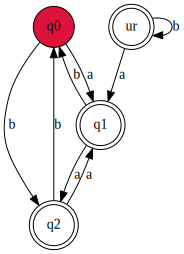

In [5]:
#@title Define & Draw DFA1
sdfa1 = '''
q0 q1 ur q2
	a b

	q1 q2
	q2 q0
	q1 ur
	q1 q0

q0
q2 q1 ur
'''
dfa1 = DFA(sdfa1)
# print(dfa1)
dfa1.draw()

q1,q2 q0

	a	b

	q1,q2	q0
	q1,q2	q1,q2

q0

q1,q2


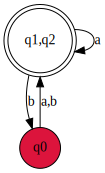

In [6]:
#@title Minimize & Draw dfa1
dfa1.minimize()
print(dfa1)
dfa1.draw()

In [7]:
print(dfa1.accepts('aabb'))
print(dfa1.accepts('abab'))

aabb is accepted:
q0	q1,q2	q1,q2	q0	q1,q2
abab is not accepted:
q0	q1,q2	q0	q1,q2	q0


# NFA

In [8]:
#@title Define NFA Class
LAMBDA = 'λ'

class NFA():

  def __init__(self, txt):

    self.color = getcolor()

    txt = txt.replace('-', LAMBDA)
    lines = [line.strip() for line in txt.split('\n') if line.strip()]

    self.Q = lines.pop(0).split()
    self.index = self.Q.index
    assert (len(set(self.Q)) == len(self.Q))

    self.Sigma = [LAMBDA] + lines.pop(0).split()

    self.extract_delta(lines[:-2])
    assert self.d.shape == (len(self.Q), len(self.Sigma))

    self.S = lines.pop(-2).strip()
    assert self.S in self.Q

    self.F = set(lines.pop(-1).split())
    if 'nofinal' in self.F: self.F = set()
    assert self.F.issubset(set(self.Q))

  def extract_delta(self, lines):
    prods = [line.split() for line in lines]
    self.d = array([[set() for _ in self.Sigma] for _ in self.Q])
    for prod in prods:
      origin, letter, dest = prod
      self.d[self.Q.index(origin), self.Sigma.index(letter)].add(self.Q.index(dest))

  def draw(self):
    g = nx.DiGraph()

    for name in self.Q:
      g.add_node(
          name,
          shape='doublecircle' if name in self.F else 'circle',
          fillcolor=self.color if name == self.S else 'white',
          style='filled'
      )

    statecount = len(self.Q)
    temp = array([[set() for _ in range(statecount)] \
                  for _ in range(statecount)])
    for origin, row in enumerate(self.d):
      for l, dests in enumerate(row):
        for dest in dests:
          letter = self.Sigma[l]
          temp[origin, dest].add(letter)

    for i, row in enumerate(temp):
      for j, letters in enumerate(row):
        if letters:
          g.add_edge(self.Q[i], self.Q[j], label=','.join(letters))

    return Source(nx.drawing.nx_agraph.to_agraph(g).unflatten())

  def lamequ(self):
    lam_tra = self.d[:, 0]
    lam_lim = sum([len(s) for s in lam_tra])
    for i in range(lam_lim):
      for _set in lam_tra:
        for q in _set:
          _set.update(lam_tra[q])
    return lam_tra

  def todfa(self):

    nalphacount = len(self.Sigma)-1

    nDelta = zeros([0, nalphacount], dtype=object)
    lamequ = self.lamequ()

    nQ = [tuple({self.index(self.S), *lamequ[self.index(self.S)]})]

    while nDelta.shape[0] < len(nQ):
      nq = nQ[nDelta.shape[0]]
      row = []
      for j in range(nalphacount):
        _set = set()
        origins = set(nq)
        {origins.update(lamequ[q]) for q in nq}      # lambda-j-transitions
        for q in origins:
          dests = self.d[q][j+1]
          _set.update(dests)                         # j-transisitions
          for dest in dests:
            _set.update(lamequ[dest])                # j-lambda-transitions
        _set = tuple(sorted(_set))
        if _set not in nQ:
          nQ.append(_set)
        row.append(nQ.index(_set))
      nDelta = append(nDelta, array([row], dtype=object), axis=0)

    string = {}
    for nq in nQ:
      l = [self.Q[q] for q in nq]
      string[nq] = ','.join(l)
      if not string[nq]:
        string[nq] = 'ϕ'

    nSigma = ' '.join(self.Sigma[1:])

    nDelta = [' '.join([
      string[nQ[dest]] for dest in row
    ]) for row in nDelta]

    nS = string[nQ[0]]

    nF = ' '.join({
      string[tup] for tup in nQ for q in tup if self.Q[q] in self.F
    })
    if not nF:
      nF = 'nofinal'

    dfas = '\n'.join([' '.join(string.values()), nSigma, *nDelta, nS, nF])
    return DFA(dfas)

  def __str__(self):
    delta = set()
    for x, row in enumerate(self.d):
      for y, z in enumerate(row):
        origin = self.Q[x]
        letter = self.Sigma[y]
        dests  = z
        delta.update({
          f'\t{origin}\t{letter}\t{self.Q[dest]}' for dest in dests
        })
    r = [
      ' '.join(self.Q),
      ' '.join(self.Sigma),
      *delta,
      self.S,
      ' '.join(self.F),
    ]
    return '\n\n'.join(r)


q0 q1 q2 q3

λ a b

	q1	a	q1

	q0	a	q1

	q1	λ	q2

	q3	b	q0

q0

q1


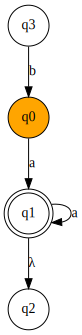

In [9]:
##@title Define & Draw NFA1

s = """
q0 q1 q2 q3
a b

  q0 a q1
  q1 - q2
  q1 a q1
  q3 b q0

q0
q1
"""

nfa1 = NFA(s)
print(nfa1)
nfa1.draw()

['q0', 'q1,q2', 'ϕ']
q0 q1,q2 ϕ

	a	b

	q1,q2	ϕ
	q1,q2	ϕ
	ϕ	ϕ

q0

q1,q2


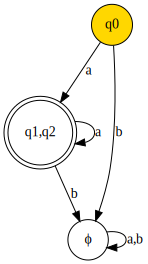

In [10]:
dfan1 = nfa1.todfa()
print(dfan1.Q)
print(dfan1)
# dfan1.draw()
dfan1.minimize()
dfan1.draw()

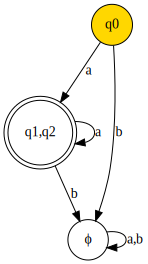

In [11]:
dfan1.minimize()
dfan1.draw()

q0 q1 q2 q3 q4 q5 q6 q7 q8

λ a b

	q6	b	q1

	q2	b	q3

	q0	a	q2

	q4	b	q3

	q6	b	q3

	q3	a	q5

	q8	a	q2

	q2	a	q5

	q5	a	q1

	q7	a	q1

	q4	b	q1

	q1	b	q0

	q0	λ	q1

	q6	a	q3

	q3	b	q3

	q8	b	q1

	q0	b	q1

	q8	a	q4

	q1	a	q2

	q1	a	q3

	q4	a	q3

	q8	λ	q1

q0

q0 q5


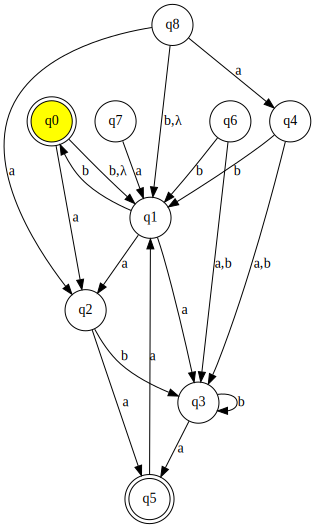

In [12]:
#@title Define & Draw NFA

nfas2 = """
q0 q1 q2 q3 q4 q5 q6 q7 q8
a b
q0 - q1
q0 a q2
q0 b q1
q1 a q3
q1 a q2
q1 b q0
q2 a q5
q2 b q3
q3 a q5
q3 b q3
q4 a q3
q4 b q1
q4 b q3
q5 a q1
q6 a q3
q6 b q1
q6 b q3
q7 a q1
q8 - q1
q8 a q2
q8 a q4
q8 b q1
q0
q0 q5
"""

nfa2 = NFA(nfas2)
print(nfa2)
nfa2.draw()

q0,q1 q2,q3 q5 q3 q1 ϕ

	a	b

	q2,q3	q0,q1
	q5	q3
	q1	ϕ
	q5	q3
	q2,q3	q0,q1
	ϕ	ϕ

q0,q1

q0,q1 q5


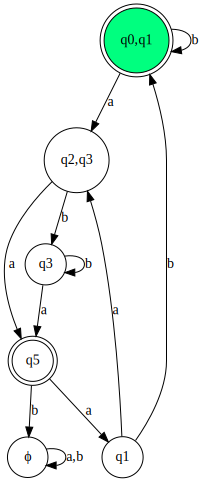

In [13]:
dfan2 = nfa2.todfa()
print(dfan2)
dfan2.draw()

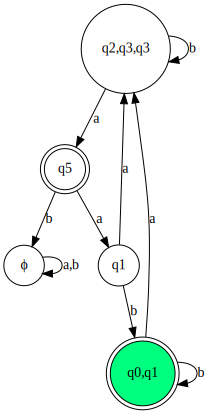

In [14]:
dfan2.minimize()
dfan2.draw()

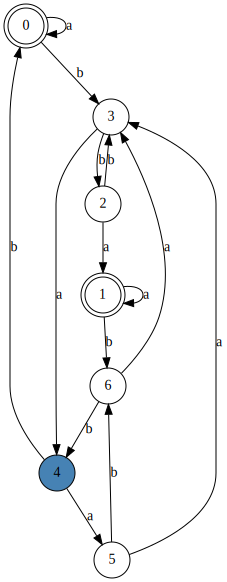

In [15]:
s = """
0 1 2 3 4 5 6

  a b

  0 3
  1 6
  1 3
  4 2
  5 0
  3 6
  3 4

4
0 1
"""

dfa = DFA(s)
dfa.draw()

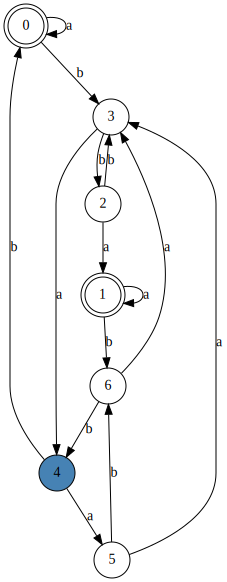

In [16]:
dfa.minimize()
dfa.draw()

# Non-Deterministic Push Down Automatan

In [17]:
#@title class NPDA

class NPDA:

  def __init__(self, txt):

    self.color = getcolor()

    txt = txt.replace('-', LAMBDA)
    lines = [line.strip() for line in txt.split('\n') if line.strip()]

    self.Q = lines.pop(0).split()
    self.index = self.Q.index
    assert (len(set(self.Q)) == len(self.Q))

    self.Sigma = [LAMBDA] + lines.pop(0).split()
    assert (len(set(self.Sigma)) == len(self.Sigma))

    self.Gamma = [LAMBDA] + lines.pop(0).split()
    assert (len(set(self.Gamma)) == len(self.Gamma))

    self.extract_delta(lines[:-2])
    print(self.d.shape , (
      len(self.Q),
      len(self.Sigma),
      len(self.Gamma),
    ))
    assert self.d.shape == (
      len(self.Q),
      len(self.Sigma),
      len(self.Gamma),
    )

    self.S = lines.pop(-2).strip()
    assert self.S in self.Q

    self.z = self.Gamma[1]

    self.F = set(lines.pop(-1).split())
    if 'nofinal' in self.F: self.F = set()
    assert self.F.issubset(set(self.Q))

  def extract_delta(self, lines):
    prods = [line.split() for line in lines]
    x = self.Q
    y = self.Sigma
    z = self.Gamma
    self.d = array([[[set() for _ in z] for _ in y] for _ in x])
    for prod in prods:
      origin, letter, sr, sw, dest = prod
      self.d[
        self.Q.index(origin),
        self.Sigma.index(letter),
        self.Gamma.index(sr),
      ].add(
        (sw, self.Q.index(dest))
      )

  def accepts(self, string):
    pass

  def __str__(self):
    return str([
      self.Q,
      self.Sigma,
      self.Gamma,
      self.d,
      self.S,
      str(self.F),
    ])
    # return '\n'.join([
    #   self.Q,
    #   self.Sigma,
    #   self.Gamma,
    #   self.d,
    #   self.S,
    #   str(self.F),
    # ])


In [18]:
npdas1 = '''
q0 q1 q2
a b
$ 1
q0 a - 1 q0
q0 - - - q1
q1 b 1 - q1
q1 - $ $ q2
q0
q2
'''

npda1 = NPDA(npdas1)
print(npda1)

(3, 3, 3) (3, 3, 3)
[['q0', 'q1', 'q2'], ['λ', 'a', 'b'], ['λ', '$', '1'], array([[[{('λ', 1)}, set(), set()],
        [{('1', 0)}, set(), set()],
        [set(), set(), set()]],

       [[set(), {('$', 2)}, set()],
        [set(), set(), set()],
        [set(), set(), {('λ', 1)}]],

       [[set(), set(), set()],
        [set(), set(), set()],
        [set(), set(), set()]]], dtype=object), 'q0', "{'q2'}"]


# Grammar

In [19]:
#@title class Grammar


from itertools import product
from collections import defaultdict
from numpy import zeros
ARR = '→'
EPS = 'ε'


varjar = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')


class Grammar(dict):

  def __init__(self, txt):
    super().__init__()
    txt = txt.replace('->',	ARR)
    txt = txt.replace(EPS,		'')
    lines = [l.strip() for l in txt.split('\n') if l]
    self.S = lines[0].split()[0]
    # self.terms = lines[1].split()
    for line in lines[2:]:
      left, right = line.split(ARR)
      left = left.strip()
      for rhs in right.split('|'):
        production = tuple(rhs.strip().split())
        if left in self.keys():
          self[left].add(production)
        else:
          self[left] = {production}
    self.varjar = varjar.copy()
    self.iscnf = False

  def __str__(self):
    return '\n'.join([
      f'CFG with {len(self.keys())} vars & start state: {self.S} & productions:'
      ] + [f'{i}\t->\t[ {" | ".join({" ".join(x) for x in j})} ]' for i, j in self.productions])

  @property
  def V(self):
    return set(self.keys())
  @property
  def productions(self):
    return self.items()

  def newvar(self):
    for varname in self.varjar:
      if varname not in self.V:
        self.varjar.remove(varname)
        return varname
    print('varjar insufficient.')
    raise varjarError

  def rm_variable(self, var):
    if var in self.V:
      self.pop(var)
    for v, rhss in self.productions:
      trash = set()
      for rhs in rhss:
        if var in rhs:
          trash.add(rhs)
      self[v] -= trash

  def rm_production(self, l, r):
    self[l].remove(r)
    if not self[l]:
      self.remove_var(l)

  def rm_unreachable(self):
    rchbl = set()
    tmp = {self.S}
    while self.V - rchbl:
      curvar = tmp.pop()
      rchbl.add(curvar)
      for v in self.V - rchbl:
        for rhs in self[curvar]:
          if v in rhs:
            tmp.add(v)
            break
      if not tmp:
        break
    for unrchbl in self.V-rchbl:
      self.rm_variable(unrchbl)

  def rm_useless(self):
    useful = set()
    changed = True
    while changed:
      changed = False
      for v in self.V - useful:
        for rhs in self[v]:
          l = [t not in self.V-useful for t in rhs]
          if False not in l:
            if v not in useful:
              useful.add(v)
              changed = True
    for v in self.V - useful:
      self.rm_variable(v)

  def sub(self, rule0, rule1, safe=False):
    warning = rule1 not in self[rule0]
    if warning and safe:
      print('Warning! Trying to sub', rule0, '=>', rule1,
            '\nWhile the vars are:', self.keys())
    for l, rs in self.productions:
      new = set()
      trash = set()
      for r in rs:
        # if rule0 in r:
        #   new.add(r.replace(rule0, rule1))
        if rule0 in r:

          trash.add(r)

          rdom = [(i,) if i==rule0 else (i, rule0) for i in r]
          # rdom = [{i, rule0} for i in r]
          new.update(set(product(rdom)))
      for t in trash:
        self.rm_production(rule0, rule1)
      self[l].update(new)

  def clean(self):
    self.rm_useless()
    self.rm_unreachable()

  def START(self):
    oldS = self.S
    if 'S0' not in self.V:
      self.S = 'S0'
    else:
      self.S = self.newvar()
    self[self.S] = {(oldS,)}

  def TERM(self):
    termvars = {}
    for a, b in self.productions:
      replacements = []
      for rhs in b:
        if len(rhs) == 1:
          continue
        newrhs = []
        for ind, element in enumerate(rhs):
          if element in self.V:
            newrhs.append(element)
          else:
            if element not in termvars.keys():
              termvars[element] = self.newvar()
            newrhs.append(termvars[element])
        if rhs != newrhs:
          replacements.append([rhs, tuple(newrhs)])
      for old, new in replacements:
        self[a].remove(old)
        self[a].add(new)
    for a, b in termvars.items():
      self[b] = {(a,)}

  def BIN(self):
    newvars = {}
    def addnewvar(tup):
      if tup in newvars.keys():
        return newvars[tup]
      else:
        newvar = self.newvar()
        d2 = tup[1:]
        newvars[d2] = (newvar,)
        dyadic = (tup[0], *addnewvar(d2))
        return (dyadic)
    for a, b in self.productions:
      olds = {rhs for rhs in b if len(rhs) > 2}
      news = {addnewvar(rhs) for rhs in olds}
      self[a] -= olds
      self[a].update(news)
    for w, v in newvars.items():
      self[v[0]] = {w}

  # def DEL(self):
    # nullables = set()
    # vars = self.V
    # for a, b in self.productions:
    #   if a == self.S:
    #     continue
    #   if '' in b:
    #     nullables.add(a)
    #     continue
    # def isnullable(v, l=[]):
    #   if v in nullables: # probably unnecessary
    #     return True
    #   b = self[v]
    #   for rhs in b:
    #     for term in rhs:
    #       if term in nullables:
    #         continue
    #       if term not in self.V:
    #         break
    #       if term in l:
    #         break
    #       l.append(term)
    #       if not isnullable(term, l):
    #         break
    #     else:
    #       return True
    #   return False
    # for v in self.V - nullables:
    #   if isnullable(v):
    #     nullables.add(v)
    # nullables -= {self.S}
    # for v in nullables:
    #   self.sub(v, '')

  def UNIT(self):
    changed = True
    while changed:
      subs = {}
      for a, b in self.productions:
        _set = {v for v in (rhs[0] for rhs in b if len(rhs) == 1) if v in self.V}
        if _set: subs[a] = _set
      subs.pop(self.S)
      changed = bool(subs)
      for x, y in subs.items():
        for v in y:
          self[x].update(self[v])
          self[x] -= {(v,)}
      subs = {}

  def tocnf(self):
    """
    The following 5 are the wikipedia methods:
    START TERM BIN DEL UNIT
    en.wikipedia.org/wiki/Chomsky_normal_form
    """

    self.clean()

    self.START()
    self.TERM()
    self.BIN()
    # self.DEL()
    self.UNIT()

    self.iscnf = True

  def generates(self, _str):

    '''
    en.wikipedia.org/wiki/CYK_algorithm
    '''

    if not self.iscnf:
      self.tocnf()

    R = [self.S] + list(self.V-{self.S})
    index = R.index
    n, r = len(_str), len(R)
    P = zeros((n, n, r), dtype='bool')
    for s in range(n):
      for v, var in enumerate(R):
        for s, rhs in enumerate(_str):
          P[0, s, v] = (rhs,) in self[var]

    for l in range(1, n):
      for s in range(n-l):
        for p in range(l):
          for a, vara in enumerate(R):
            bins = [(
              index(rhs[0]), index(rhs[1])
            ) for rhs in self[vara] if len(rhs)==2]
            for b, c in bins:
              _bool = P[p, s, b] and P[l-p-1, s+p+1, c]
              if _bool:
                P[l, s, a] = True

    return P[-1, 0].any()


In [20]:
#@title Grammar example 1

s = '''
Expr Term Factor Primary AddOp MulOp
^ ( ) + - * /
Expr	  →   Term	  | Expr AddOp Term   | AddOp Term
Term	  →   Factor	| Term MulOp Factor
Factor	→   Primary	| Factor ^ Primary
Primary	→   number	| variable	        | ( Expr )
AddOp	  →   +	      | −
MulOp	  →   *	      | /
'''

g = Grammar(s)
print(g)
print(80*'_')
g.tocnf()
print(g)
# print(g.generates(('she', 'eats', 'a', 'fish', 'with', 'a', 'fork')))
# print(g.generates(('she', 'eats', 'a', 'fish', 'with', 'a', 'fork')))
ts = [
  ('(', 'number', '*', 'number', ')', '+'),
  ('(', 'number', '*', 'number', ')', '^', 'variable')
]
for t in ts:
  print(' '.join(t))
  print(g.generates(t))

if 1:
  pass
  # t = '''
  # S AB|BA|SS|T|
  # A aaa|aa|a
  # B bS|Sb
  # T aBaa|aaBa|aBa'''
  # s = '''
  # S AaS|aaDA|bLR|ab
  # A Aa|Ab|SR|DR|
  # D RD|aD|DS|Eb
  # L a
  # R b
  # '''
  # s = '''
  # S aAb|aBc|bCc
  # A 1
  # B 2|
  # C C3B|3CA
  # E
  # '''
  # s = '''
  # S VP PP NP V P N N Det
  # she eats a fish with a fork
  # S -> NP VP
  # VP -> VP PP
  # VP -> V NP
  # VP -> eats
  # PP -> P NP
  # NP -> Det N
  # NP -> she
  # V -> eats
  # P -> with
  # N -> fish
  # N -> fork
  # Det -> a
  # '''


CFG with 6 vars & start state: Expr & productions:
Expr	->	[ Expr AddOp Term | Term | AddOp Term ]
Term	->	[ Factor | Term MulOp Factor ]
Factor	->	[ Factor ^ Primary | Primary ]
Primary	->	[ ( Expr ) | number | variable ]
AddOp	->	[ − | + ]
MulOp	->	[ / | * ]
________________________________________________________________________________
CFG with 14 vars & start state: S0 & productions:
Expr	->	[ Factor F | B G | Expr D | number | Term E | variable | AddOp Term ]
Term	->	[ Factor F | B G | number | Term E | variable ]
Factor	->	[ variable | number | Factor F | B G ]
Primary	->	[ variable | number | B G ]
AddOp	->	[ − | + ]
MulOp	->	[ / | * ]
S0	->	[ Expr ]
A	->	[ ^ ]
B	->	[ ( ]
C	->	[ ) ]
D	->	[ AddOp Term ]
E	->	[ MulOp Factor ]
F	->	[ A Primary ]
G	->	[ Expr C ]
( number * number ) +
False
( number * number ) ^ variable
True


In [21]:
#@title Grammar Example 2

Gs2 = '''
S
a b
S → S S | a S b | b S a | a b | b a
'''
g2 = Grammar(Gs2)
g2.tocnf()
print(g2)
# print(g2.generates('aaaabbbb'.split()))
# print(g2.generates('bbabbaaa'.split()))
print(g2.generates('abab'.split()))


CFG with 6 vars & start state: S0 & productions:
S	->	[ B C | B A | A B | S S | A D ]
S0	->	[ S ]
A	->	[ a ]
B	->	[ b ]
C	->	[ S A ]
D	->	[ S B ]
False


# Turing Machine

In [22]:
#@markdown ### Define Constants

N = 1000

R, L = 'R', 'L'

blank = '□'
SPECIAL_CHARS = {
  'blank' : blank,
}


In [23]:
#@title Define Tape Class

class Tape(list):

  def __init__(self, string):
    super().__init__(string)
    self.ind = 0
    self._len = len(string)

  def read(self):
    return self[self.ind]

  def write(self, letter):
    self[self.ind] = letter

  def chop(self):
    return self[:self.ind], self[self.ind:]

  def left(self):
    if self.ind > 0:
      self.ind -= 1
    else:
      self.insert(0, blank)
      self._len += 1
  def right(self):
    self.ind += 1
    if self.ind == self._len:
      self.append(blank)
      self._len += 1


In [24]:
#@title class TM

class TM:

  def __init__(self, txt):

    for string, spch in SPECIAL_CHARS.items():
      txt = txt.replace(string, spch)

    lines = txt.split('\n')
    while '' in lines:
      lines.remove('')

    Q = lines.pop(0)
    Sigma = lines.pop(0)
    G = lines.pop(0)
    # delta
    S = lines.pop(-2)
    F = lines.pop(-1)
    d = lines

    def setify(string):
      return set(string.split())

    self.Q = setify(Q)
    self.Sigma = setify(Sigma)
    self.G = setify(G)
    self.d = self.extract_delta(d)
    self.S = S.split()[0]
    self.F = setify(F)

  def extract_delta(self, lines):
    destination = namedtuple('destination', ['state', 'letter', 'direction'])
    d = {
      tuple(l.split()[0:2]) : destination(*l.split()[2:]) for l in lines
    }
    return d

  def accepts(self, string):

    curstate = self.S
    tape = Tape(string)
    lines = []

    def inststate():
      bef, aft = tape.chop()
      return '  '.join([*bef, curstate, *aft])

    for _ in range(N):
      lines.append(inststate())
      try:
        dest = self.d[(curstate, tape.read())]
        curstate = dest.state
        tape.write(dest.letter)
        if dest.direction == L: tape.left()
        if dest.direction == R: tape.right()
      except KeyError:
        if curstate in self.F:
          lines.append(f'Accept')
          _bool = True
        else:
          lines.append('Halt & Reject')
          _bool = False
        txt = '\n'.join(lines)
        return Accept(_bool, string, txt)

  def __str__(self):
    arrow = '→'
    delta = []
    for origin, dest in self.d.items():
      delta.append('\t'.join([
                    f'({origin[0]})\t{origin[1]} {arrow} {dest.letter} , {dest.direction}\t({dest.state})'
      ]))
    delta = 'd: {\n\t' + '\n\t'.join(delta) + '\n}'
    lines = [
             f'Q: {self.Q}',
             f'Sigma: {self.Sigma}',
             f'G: {self.G}',
             delta,
             f'S: {self.S}',
             f'F: {self.F}',
    ]
    return '\n'.join(lines)


In [25]:
#@title TM example 1

s1 = '''
q0 q1 q2
a b
a b blank
q0  a q1  a R
q1  a q0  a R
q0  b q1  b R
q1  b q0  b R
q1  blank q2  blank L
q0
q2
'''

tm1 = TM(s1)
print(tm1)
print(tm1.accepts('aabba'))
print(tm1.accepts('babaabba'))

Q: {'q1', 'q2', 'q0'}
Sigma: {'a', 'b'}
G: {'a', 'b', '□'}
d: {
	(q0)	a → a , R	(q1)
	(q1)	a → a , R	(q0)
	(q0)	b → b , R	(q1)
	(q1)	b → b , R	(q0)
	(q1)	□ → □ , L	(q2)
}
S: q0
F: {'q2'}
aabba is accepted:
q0  a  a  b  b  a
a  q1  a  b  b  a
a  a  q0  b  b  a
a  a  b  q1  b  a
a  a  b  b  q0  a
a  a  b  b  a  q1  □
a  a  b  b  q2  a  □
Accept
babaabba is not accepted:
q0  b  a  b  a  a  b  b  a
b  q1  a  b  a  a  b  b  a
b  a  q0  b  a  a  b  b  a
b  a  b  q1  a  a  b  b  a
b  a  b  a  q0  a  b  b  a
b  a  b  a  a  q1  b  b  a
b  a  b  a  a  b  q0  b  a
b  a  b  a  a  b  b  q1  a
b  a  b  a  a  b  b  a  q0  □
Halt & Reject


In [26]:
#@title TM example 2

s2 = '''
q0 q1 q2 q3 q4
a b
a b y x blank
q0  a q1  x R
q1  a q1  a R
q1  y q1  y R
q1  b q2  y L
q2  y q2  y L
q2  a q2  a L
q2  x q0  x R
q0  y q3  y R
q3  y q3  y R
q3  blank q4  blank R
q0
q4
'''

tm2 = TM(s2)
print(tm2)
print(tm2.accepts('aabba'))
print(tm2.accepts('aabb'))

Q: {'q1', 'q2', 'q0', 'q3', 'q4'}
Sigma: {'a', 'b'}
G: {'a', 'b', 'x', '□', 'y'}
d: {
	(q0)	a → x , R	(q1)
	(q1)	a → a , R	(q1)
	(q1)	y → y , R	(q1)
	(q1)	b → y , L	(q2)
	(q2)	y → y , L	(q2)
	(q2)	a → a , L	(q2)
	(q2)	x → x , R	(q0)
	(q0)	y → y , R	(q3)
	(q3)	y → y , R	(q3)
	(q3)	□ → □ , R	(q4)
}
S: q0
F: {'q4'}
aabba is not accepted:
q0  a  a  b  b  a
x  q1  a  b  b  a
x  a  q1  b  b  a
x  q2  a  y  b  a
q2  x  a  y  b  a
x  q0  a  y  b  a
x  x  q1  y  b  a
x  x  y  q1  b  a
x  x  q2  y  y  a
x  q2  x  y  y  a
x  x  q0  y  y  a
x  x  y  q3  y  a
x  x  y  y  q3  a
Halt & Reject
aabb is accepted:
q0  a  a  b  b
x  q1  a  b  b
x  a  q1  b  b
x  q2  a  y  b
q2  x  a  y  b
x  q0  a  y  b
x  x  q1  y  b
x  x  y  q1  b
x  x  q2  y  y
x  q2  x  y  y
x  x  q0  y  y
x  x  y  q3  y
x  x  y  y  q3  □
x  x  y  y  □  q4  □
Accept


#نظریه زبان ها و ماشین ها